## <font color='red'> NOTE: this notebook is executed on Google Colab

In [0]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
%matplotlib inline

## 1.1 Implementation


In [0]:
#deal with tensors
import torch   
#handling text data
from torchtext import data 
#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [0]:
tokenize = lambda x: list(x)

TEXT = data.Field(tokenize=tokenize,batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
fields = [('text',TEXT),('label', LABEL)]
#loading custom dataset
train_data=data.TabularDataset(path = 'tweets_train.csv',format = 'csv',fields = fields,skip_header = False)
test_data=data.TabularDataset(path = 'tweets_test.csv',format = 'csv',fields = fields,skip_header = False)
#print preprocessed text
print(vars(train_data.examples[1]))

{'text': ['@', 'm', 'i', 'c', 'h', 'e', 'l', 'l', 'e', 'b', 'r', 'a', 'n', 'c', 'h', ' ', 'o', 'h', ' ', 'm', 'y', '!', '!', '!', ' ', ' ', 'I', ' ', 'h', 'o', 'p', 'e', ' ', 't', 'h', 'e', ' ', 'v', 'i', 'd', 'e', 'o', 's', 'h', 'o', 'o', 't', ' ', 'i', 's', ' ', 'k', 'i', 'c', 'k', 'a', 's', 's', ' ', 't', 'h', 'e', 'n', '!', ' '], 'label': '0'}


In [0]:
print(vars(test_data.examples[0]))

{'text': ['I', 't', "'", 's', ' ', 'b', 'e', 'e', 'n', ' ', '5', ' ', 'y', 'e', 'a', 'r', 's', ' ', 's', 'i', 'n', 'c', 'e', ' ', 'm', 'y', ' ', 'f', 'r', 'i', 'e', 'n', 'd', ' ', 'w', 'a', 's', ' ', 'k', 'i', 'l', 'l', 'e', 'd', ' ', 'b', 'y', ' ', 'a', ' ', 'h', 'i', 't', ' ', 'a', 'n', 'd', ' ', 'r', 'u', 'n', ' ', 'd', 'r', 'i', 'v', 'e', 'r', '.', ' ', 'M', 'i', 's', 's', ' ', 'h', 'e', 'r', '.', ' '], 'label': '0'}


In [0]:
len(train_data), len(test_data)

(90000, 10000)

In [0]:
#initialize glove embeddings
TEXT.build_vocab(train_data)  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

Size of TEXT vocabulary: 95
Size of LABEL vocabulary: 2
[(' ', 1201631), ('e', 508366), ('o', 427913), ('t', 424662), ('a', 387865), ('i', 324848), ('n', 319198), ('s', 278066), ('r', 242483), ('h', 231233)]
defaultdict(<function _default_unk_index at 0x7ff0270bbb70>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'i': 7, 'n': 8, 's': 9, 'r': 10, 'h': 11, 'l': 12, 'd': 13, 'u': 14, 'm': 15, 'y': 16, 'g': 17, 'w': 18, '.': 19, 'c': 20, 'p': 21, 'f': 22, 'b': 23, 'k': 24, '!': 25, 'I': 26, 'v': 27, '@': 28, "'": 29, ',': 30, 'T': 31, 'S': 32, 'A': 33, 'M': 34, '/': 35, 'O': 36, 'j': 37, '?': 38, 'x': 39, 'H': 40, 'L': 41, 'E': 42, 'N': 43, 'W': 44, 'B': 45, 'D': 46, 'C': 47, 'G': 48, ';': 49, 'z': 50, '-': 51, 'R': 52, '&': 53, '1': 54, ':': 55, 'P': 56, '2': 57, 'Y': 58, '0': 59, 'F': 60, 'q': 61, 'J': 62, '3': 63, '_': 64, 'U': 65, 'K': 66, '4': 67, '5': 68, '6': 69, 'V': 70, '8': 71, '7': 72, '9': 73, ')': 74, '#': 75, '(': 76, '*': 77, 'X': 78, 'Z': 79, 'Q': 80, '='

In [0]:
#set batch size
BATCH_SIZE = 32

#Load an iterator
train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [0]:
import torch.nn as nn

class classifier(nn.Module):
    
    def __init__(self, vocab_size, hidden_dim, output_dim, n_layers):
        super().__init__()          

        self.lstm = nn.LSTM(vocab_size, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        embedding = nn.functional.one_hot(text, num_classes=len(TEXT.vocab)) # convert to one hot embedding
        embedding = embedding.float()

        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedding, text_lengths,batch_first=True)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        dense_outputs=self.fc(hidden)

        outputs=self.act(dense_outputs)
        
        return outputs

In [0]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab) # Our input size is 95
num_hidden_nodes = 128
num_output_nodes = 1
num_layers = 1

#instantiate the model
model = classifier(size_of_vocab, num_hidden_nodes,num_output_nodes, num_layers)

In [0]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (lstm): LSTM(95, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 115,329 trainable parameters


In [0]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()                                

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [0]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  

    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
# we will train for 50 * 90,000 / 32 = 140k iterations
N_EPOCHS = 50
train_acc_history = []
test_acc_history = []

In [0]:
for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    
    # save history
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    print(f"================ Epoch {epoch+1}/{N_EPOCHS} ================")
    print(f'Train Loss: {train_loss:.3f}\t Train Acc: {train_acc*100:.2f}%')
    print(f'Test Loss: {test_loss:.3f}\t Test Acc: {test_acc*100:.2f}%')

================ Epoch 1/50 ================
Train Loss: 0.684	 Train Acc: 55.56%
Test Loss: 0.668	 Test Acc: 60.16%
================ Epoch 2/50 ================
Train Loss: 0.650	 Train Acc: 62.46%
Test Loss: 0.647	 Test Acc: 61.87%
================ Epoch 3/50 ================
Train Loss: 0.640	 Train Acc: 63.64%
Test Loss: 0.634	 Test Acc: 64.57%
================ Epoch 4/50 ================
Train Loss: 0.636	 Train Acc: 64.20%
Test Loss: 0.629	 Test Acc: 65.01%
================ Epoch 5/50 ================
Train Loss: 0.629	 Train Acc: 64.77%
Test Loss: 0.623	 Test Acc: 65.54%
================ Epoch 6/50 ================
Train Loss: 0.623	 Train Acc: 65.38%
Test Loss: 0.614	 Test Acc: 66.58%
================ Epoch 7/50 ================
Train Loss: 0.616	 Train Acc: 66.14%
Test Loss: 0.616	 Test Acc: 66.34%
================ Epoch 8/50 ================
Train Loss: 0.610	 Train Acc: 66.88%
Test Loss: 0.600	 Test Acc: 67.64%
================ Epoch 9/50 ================
Train Loss: 0.604	 

## 1.2 Plots

Text(0, 0.5, 'Training Accuracy')

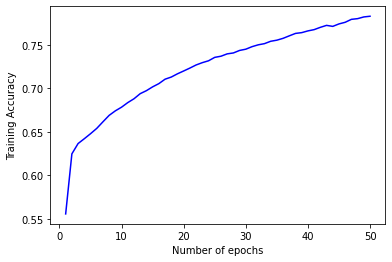

In [0]:
epoches = [i+1 for i in range(N_EPOCHS)]
plt.plot(epoches, train_acc_history, 'b-')
plt.xlabel('Number of epochs')
plt.ylabel('Training Accuracy')

Text(0, 0.5, 'Test Accuracy')

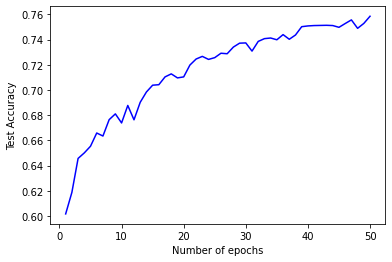

In [0]:
plt.plot(epoches, test_acc_history, 'b-')
plt.xlabel('Number of epochs')
plt.ylabel('Test Accuracy')

Text(0, 0.5, 'Training and Test Accuracy')

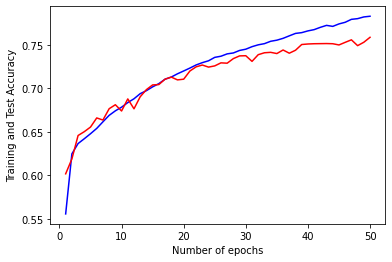

In [0]:
plt.plot(epoches, train_acc_history, 'b-')
plt.plot(epoches, test_acc_history, 'r-')
plt.xlabel('Number of epochs')
plt.ylabel('Training and Test Accuracy')